# Assignment 5


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Clarissa Ding
* Fan Chen

---

In [19]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

import pandas as pd

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

from sklearn.preprocessing import LabelEncoder

## Problem 1: Automatic Hubble (3pts)

Go back to Assignment 3. Get the Hubble data and take the GP error model from Problem 1.3 to solve the linear regression with correlated errors, but this time use `emcee` to get the posteriors.

Adopt non-informative priors, i.e. $p(b) \propto (1+b^2)^{-3/2}$ and $p(\sigma_y)\propto 1/\sigma_y$, and whatever you feel is appropriate for the priors of the parameter $\alpha$ and $\tau$ of the Matern kernel.

Plot the parameter contours with `corner` and make another plot that compares the data with samples of the posterior.

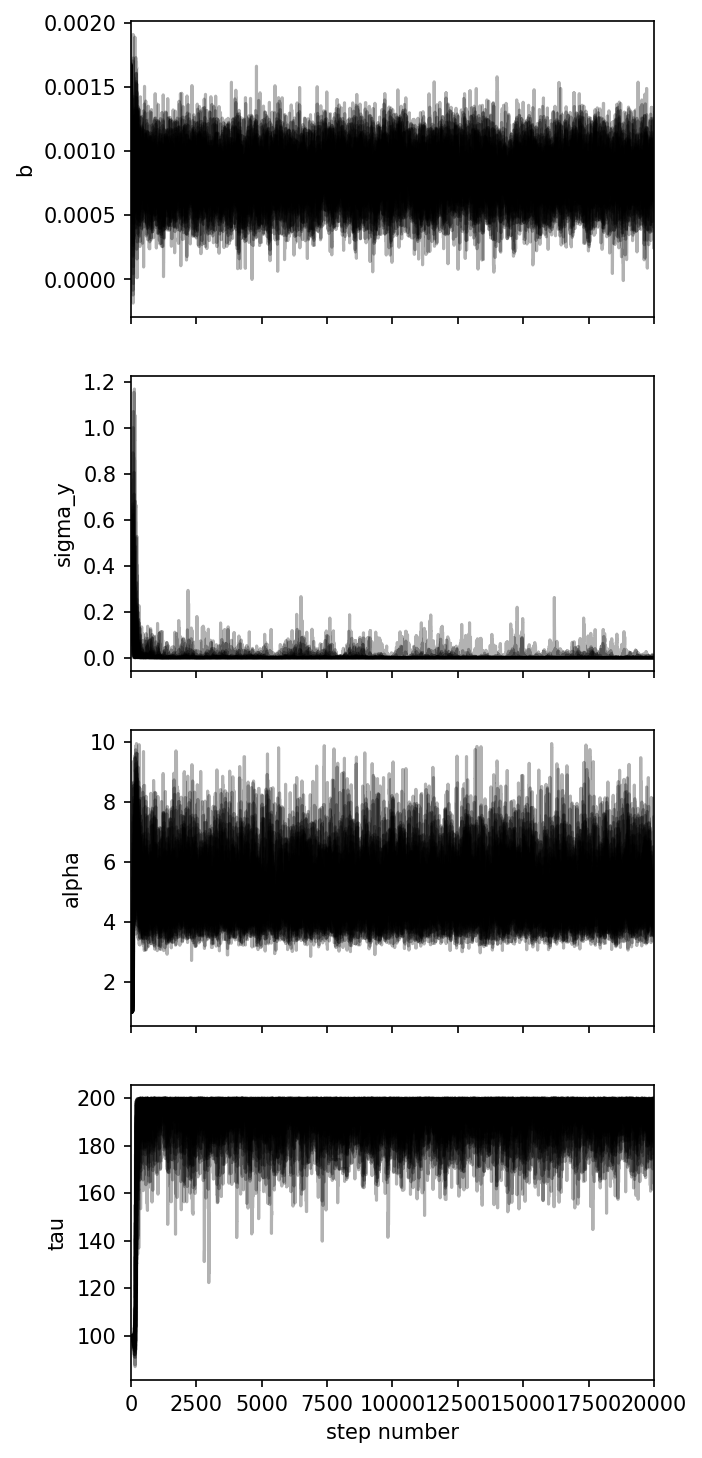

In [43]:
### priors for b and sigma_y as instructed
data = np.genfromtxt('hubble_corrected.txt',names=True,dtype=None,encoding=None)
x = data['V'].reshape((-1,1))
y = data['R']

def matern_3_2(X,X_,alpha,tau):
    d = np.sqrt(np.power((X-X_.T),2.0))
    d_ = np.sqrt(3)*d/tau
    k = np.power(alpha,2.0)*(1+d_)*np.exp(-d_)
    return k

def log_likelihood(theta, x, y):
    b,sigma_y,alpha,tau = theta
    model = b * x
    e = y-model
    N = np.shape(e)[0]
    noise_cov = np.eye(N)*np.power(sigma_y,2.0)
    K_theta = matern_3_2(x,x,alpha,tau)
    K_y = K_theta+noise_cov
    ans = -0.5*np.sum(e.T @ (np.linalg.inv(K_y) @ e))
    ans -= 0.5 * np.log(np.linalg.det(K_y))
    return ans

def log_prior(theta):
    b,sigma_y,alpha,tau = theta
    if sigma_y < 0:
        return -np.inf  # log(0)
    if 0.0 < alpha < 10.0 and 0.0 < tau < 200.0:
        return -np.log(sigma_y) - 1.5 * np.log(1 + b*b)
    return -np.inf

def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)


# start at the MLE
x_mle = 0.00166177, 0.09994323, 0.9999702, 100.0

# create a small ball around the MLE the initialize each walker 
nwalkers, ndim = 30, 4
pos = x_mle + 1e-5 * np.random.randn(nwalkers, ndim)

# run emcee
mcsteps = 20000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, mcsteps, progress=False);

# tau = sampler.get_autocorr_time()
# print(tau)


fig, axes = plt.subplots(ndim, sharex=True,figsize=(4.5,12),dpi=150)
samples = sampler.get_chain()
labels = ["b","sigma_y","alpha","tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, rasterized=True)
    ax.set_xlim(0, mcsteps)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");


In [44]:
### get correlation length
tau = sampler.get_autocorr_time()
print(tau)

[186.89991715 221.78062641 152.03827481 215.8396564 ]


(5910, 4)


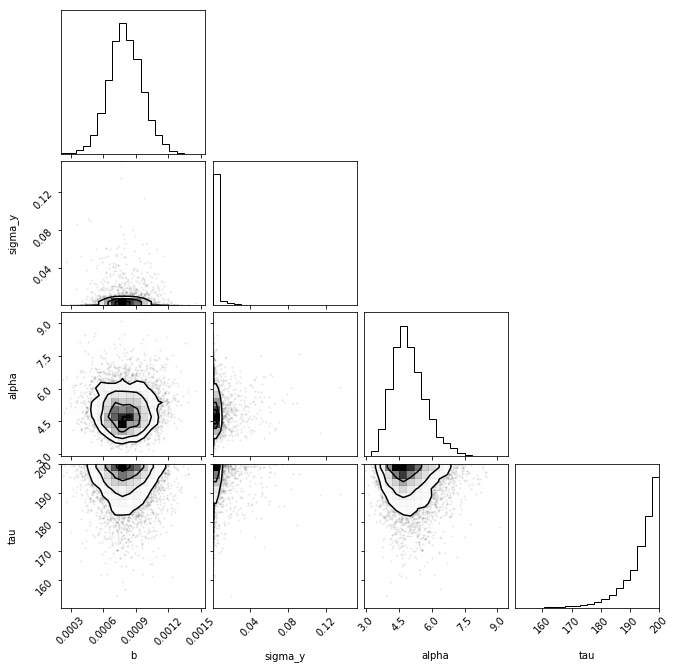

In [45]:
flat_samples = sampler.get_chain(discard=300, thin=100, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels)

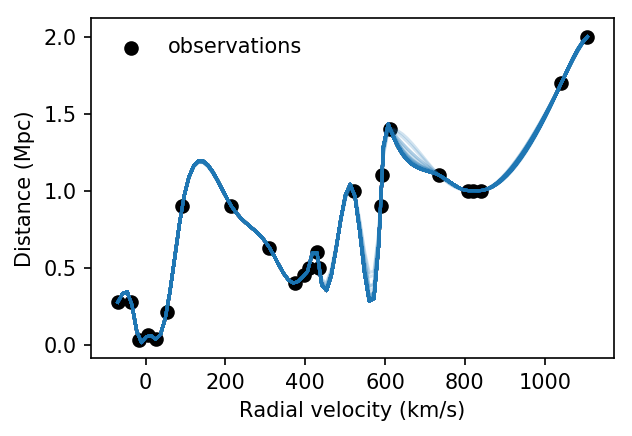

In [46]:
inds = np.random.randint(len(flat_samples), size=100)
x0 = np.linspace(min(x), max(x), 100).reshape(-1,1)
N = x.shape[0]

fig = plt.figure(figsize=(4.5,3),dpi=150)
for ind in inds:
    sample = flat_samples[ind]
    b,sigma_y,alpha,tau = sample
    e = y - np.dot(x,b.reshape(-1,1)).flatten()
    mu_s = np.dot(x0,b.reshape(-1,1)).flatten()
    K_xs = matern_3_2(x,x0,alpha,tau)
    Kx = matern_3_2(x,x,alpha,tau)+np.eye(N)*np.power(sigma_y,2.0)
    mu_s_X = np.dot(K_xs.T,np.dot(np.linalg.inv(Kx),e))
    y_pred = mu_s + mu_s_X
    plt.plot(x0, y_pred, "C0", alpha=0.2)


plt.scatter(x,y,color='black',label='observations')
plt.xlabel('Radial velocity (km/s)')
plt.ylabel('Distance (Mpc)');
plt.legend(loc=0, frameon=False)    
plt.show()

## Problem 2: HMC for Hierarchical Regression (7pts)

Implement the hierarchical linear regression model for math scores vs socio-econonic status (SES) from 100 schools we discussed in the lecture on Gibbs sampling. Use `numpyro` and compute posteriors with HMC/NUTS.

## Problem 2.1 (3pts):

Get the data from the Hoff 2009 book [here](https://github.com/probml/pmtk3/blob/master/data/mathDataHoff.csv).
Treat each school independently and perform linear regression (with an unknown error) of math score as function of SES. Adopt the inverse Gamma distribution as hyperprior for the noise $\sigma$.

Compute the mean of the posterior predictive distribution over the relevant range in SES for every school. Make a plot of these per-school mean predictions (see Murphy Fig. 24.4). Store the posterior means of $w_j$ and $\sigma_j$ for every school for Problem 2.3.

**Hint**: 

```
import jax.numpy as np
import numpy as onp
```

In [28]:
### data loading

train = pd.read_csv('mathDataHoff.txt')
train.head()

,sch_id,sch_freelunch,stu_ses,stu_mathscore
0,1011,6,-0.059948,52.11
1,1011,6,1.051652,57.65
2,1011,6,-0.863515,66.44
3,1011,6,-0.796551,44.68
4,1011,6,-1.613511,40.57


### Model: $y_i=X_i w_i + e_i$
where $e_i \sim N(0, \sigma^2)$, and the hyperprior for $\sigma$ is $p(\sigma^2) = IG(\frac{1}{2}\nu_0,\frac{1}{2}\nu_0 \sigma^2_0)$

In [50]:
### model specification and training


### using wide range of flat priors equivalent to no-pooling method
### range of priors taken from Fig.11.1 of Hoff2009 book
### each school has its own sigma2
def model(sch_id, x, y_obs=None):
    nu0 = 1
    sigma2_0 = 100
    n_students = len(np.unique(sch_id))
    
    with numpyro.plate("plate_i", n_students):
        a = numpyro.sample('a', dist.Uniform(30., 70.))
        b = numpyro.sample('b', dist.Uniform(-20., 20.))
        sigma2 = numpyro.sample("σ", dist.InverseGamma(0.5*nu0,0.5*nu0*sigma2_0))
    
    y_est = a[sch_id] + b[sch_id] * x

    with numpyro.plate("data", len(sch_id)):
        numpyro.sample("obs", dist.Normal(y_est, sigma2[sch_id]), obs=y_obs)
        

sch_encoder = LabelEncoder()
train["sch_id"] = sch_encoder.fit_transform(train["sch_id"].values)

y_obs = train["stu_mathscore"].values
x = train["stu_ses"].values
sch_id = train["sch_id"].values


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sch_id, x, y_obs=y_obs)

posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 4000/4000 [00:10<00:00, 378.36it/s, 31 steps of size 1.99e-01. acc. prob=0.87]


In [51]:
### store posterior means of w_j and sigma_j
posterior_samples = mcmc.get_samples()
w_j_mean1 = np.zeros((len(np.unique(sch_id)),2))
w_j_mean1[:,0] = np.mean(posterior_samples['a'],axis=0)
w_j_mean1[:,1] = np.mean(posterior_samples['b'],axis=0)
sigma_j_mean1 = np.mean(posterior_samples['σ'],axis=0)

### Compute the mean of the posterior predictive distribution 
### over the relevant range in SES for every school
ses_range = np.arange(min(x), max(x))
predictive = Predictive(model, posterior_samples)
mean_post_pred = np.zeros((len(np.unique(sch_id)),ses_range.shape[0]))

for j in range(ses_range.shape[0]):              
    predictions = predictive(random.PRNGKey(0),sch_encoder.fit_transform(train["sch_id"].values), ses_range[j], None)['obs']
    mean_predictions = np.mean(predictions,axis=0)
    d = {'sch_id': sch_encoder.fit_transform(train["sch_id"].values), 'post_pred':mean_predictions}
    df = pd.DataFrame(data=d)
    mean_post_pred[:,j] = df.groupby('sch_id').mean()['post_pred']
                        

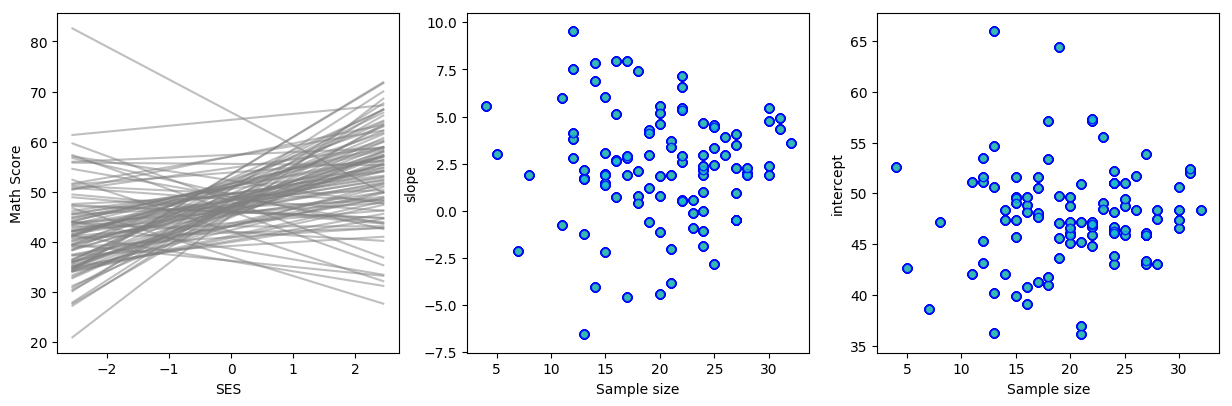

In [64]:
### plot per-school mean predictions
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4.5),dpi=100)

for i in range(len(np.unique(sch_id))):
    ax1.plot(ses_range,mean_post_pred[i,:], color='gray', alpha=0.5)
    ax2.scatter([len(train['stu_ses'][train['sch_id'] == i]) for i in np.unique(sch_id)], w_j_mean1[:,1],edgecolors='blue', alpha=0.8)
    ax3.scatter([len(train['stu_ses'][train['sch_id'] == i]) for i in np.unique(sch_id)], w_j_mean1[:,0],edgecolors='blue', alpha=0.8)

ax1.set_xlabel('SES')
ax1.set_ylabel('Math Score')   
ax2.set_ylabel('slope')
ax2.set_xlabel('Sample size') 
ax3.set_ylabel('intercept')
ax3.set_xlabel('Sample size') 
plt.show()

### Problem 2.2 (3pts):

Now implement the full hierarchical scheme for the school regression coefficient $w_j$ we introduced in the lecture. Use the same hyperprior parameters for the inverse Gamma distribution of $\sigma$ you used in 2.1.

Make a corner plot of the posterior for the full set of parameters. In another plot, show the mean posterior prediction for every school. Store the posterior means of $w_j$ for every school and of the global $\sigma$ for Problem 2.3.

**Hint:** The inverse Wishart distribution is not available in NumPyro yet. For univariate cases, it is identical to the inverse Gamma distribution, but for the $2\times 2$ covariance $\Sigma$, we assume independence of the slope and the intercept variances. Thus, sample two independent RVs from the inverse Gamma and combine them into a diagonal matrix covariance matrix. 

In [65]:
### model specification and training

nu0 = 1
sigma2_0 = 100
mu0_a = np.mean(w_j_mean1[:,0])
mu0_b = np.mean(w_j_mean1[:,1])
v0_a = np.var(w_j_mean1[:,0])
v0_b = np.var(w_j_mean1[:,1])
nu0_a = 5
sigma2_0_a = 100
nu0_b = 1
sigma2_0_b = 50


def model(sch_id, x, y_obs=None):    
    mu_a =  numpyro.sample("μa", dist.Normal(mu0_a, v0_a))
    mu_b =  numpyro.sample("μb", dist.Normal(mu0_b, v0_b))
    Sig_a = numpyro.sample("Σa",dist.InverseGamma(0.5*nu0_a, 0.5*nu0_a*sigma2_0_a))
    Sig_b = numpyro.sample("Σb",dist.InverseGamma(0.5*nu0_b, 0.5*nu0_b*sigma2_0_b))
    n_students = len(np.unique(sch_id))
    
    with numpyro.plate("plate_i", n_students):
        a = numpyro.sample("a", dist.Normal(mu_a, Sig_a))
        b = numpyro.sample("b", dist.Normal(mu_b, Sig_b))
        
    sigma2 = numpyro.sample("σ", dist.InverseGamma(0.5*nu0,0.5*nu0*sigma2_0))
    y_est =  a[sch_id] + b[sch_id] * x

    with numpyro.plate("data", len(sch_id)):
        numpyro.sample("obs", dist.Normal(y_est, sigma2), obs=y_obs)
        

sch_encoder = LabelEncoder()
train["sch_id"] = sch_encoder.fit_transform(train["sch_id"].values)

y_obs = train["stu_mathscore"].values
x = train["stu_ses"].values
sch_id = train["sch_id"].values


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sch_id, x, y_obs=y_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:09<00:00, 404.05it/s, 15 steps of size 2.75e-01. acc. prob=0.90]


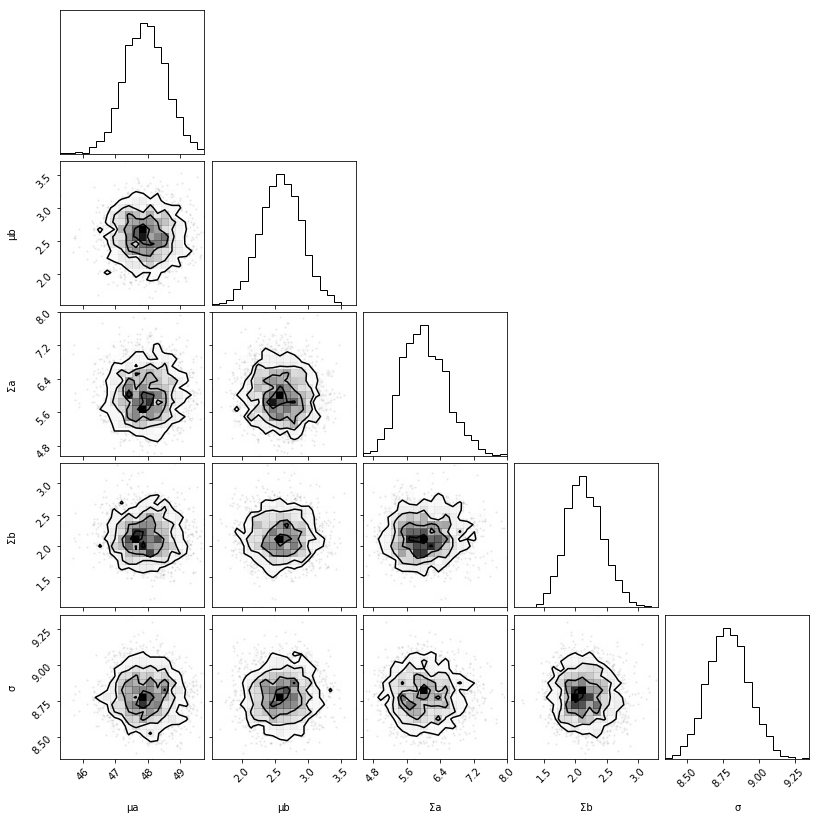

In [66]:
### Make a corner plot of hyper-parameters
posterior_samples = mcmc.get_samples()
pos_mu_a = np.array(posterior_samples['μa'])
pos_Sig_a = np.array(posterior_samples['Σa'])
pos_mu_b = np.array(posterior_samples['μb'])
pos_Sig_b = np.array(posterior_samples['Σb'])
pos_sigma2 = np.array(posterior_samples['σ'])
d = {'μa': pos_mu_a,'μb': pos_mu_b,'Σa':pos_Sig_a,'Σb':pos_Sig_b, 'σ':pos_sigma2}
df = pd.DataFrame(data=d)
lbs = ['μa','μb','Σa','Σb','σ']
fig = corner.corner(df,labels=lbs)

In [67]:
### store posterior means of w_j and sigma
w_j_mean2 = np.zeros((len(np.unique(sch_id)),2))
w_j_mean2[:,0] = np.mean(posterior_samples['a'],axis=0)
w_j_mean2[:,1] = np.mean(posterior_samples['b'],axis=0)
sigma_mean2 = np.mean(posterior_samples['σ'],axis=0)

### Compute the mean of the posterior predictive distribution 
### over the relevant range in SES for every school
ses_range = np.arange(min(x), max(x))
predictive = Predictive(model, posterior_samples)
mean_post_pred = np.zeros((len(np.unique(sch_id)),ses_range.shape[0]))

for j in range(ses_range.shape[0]):              
    predictions = predictive(random.PRNGKey(0),sch_encoder.fit_transform(train["sch_id"].values), ses_range[j], None)['obs']
    mean_predictions = np.mean(predictions,axis=0)
    d = {'sch_id': sch_encoder.fit_transform(train["sch_id"].values), 'post_pred':mean_predictions}
    df = pd.DataFrame(data=d)
    mean_post_pred[:,j] = df.groupby('sch_id').mean()['post_pred']

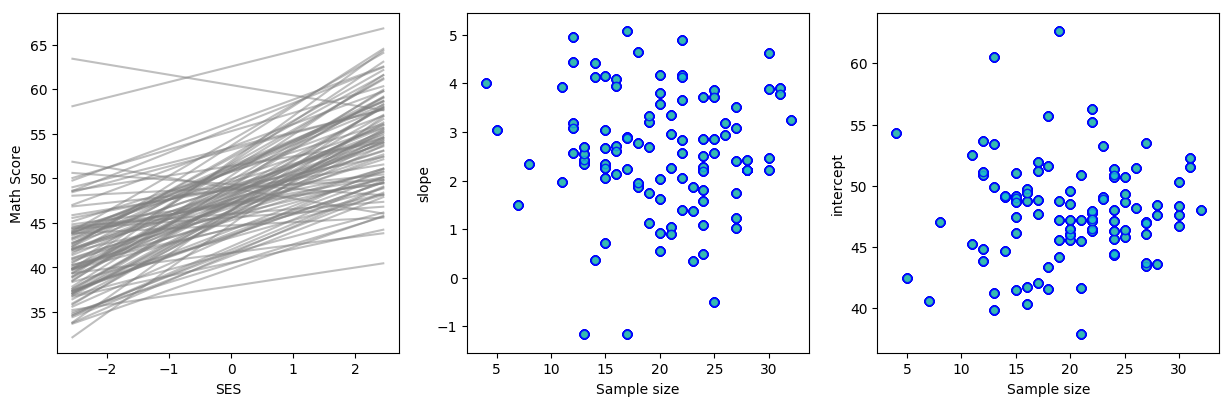

In [68]:
### plot per-school mean predictions
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4.5),dpi=100)

for i in range(len(np.unique(sch_id))):
    ax1.plot(ses_range,mean_post_pred[i,:], color='gray', alpha=0.5)
    ax2.scatter([len(train['stu_ses'][train['sch_id'] == i]) for i in np.unique(sch_id)], w_j_mean2[:,1],edgecolors='blue', alpha=0.8)
    ax3.scatter([len(train['stu_ses'][train['sch_id'] == i]) for i in np.unique(sch_id)], w_j_mean2[:,0],edgecolors='blue', alpha=0.8)

ax1.set_xlabel('SES')
ax1.set_ylabel('Math Score')   
ax2.set_ylabel('slope')
ax2.set_xlabel('Sample size') 
ax3.set_ylabel('intercept')
ax3.set_xlabel('Sample size') 
plt.show()

### Problem 2.3 (1pt):

Make a [quiver plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) with the coordinates $(w_j, \sigma_j)$ from 2.1 as starting points and $(w_j,\sigma)$ from 2.2 as end points (one arrow per school). Interpret the result. 

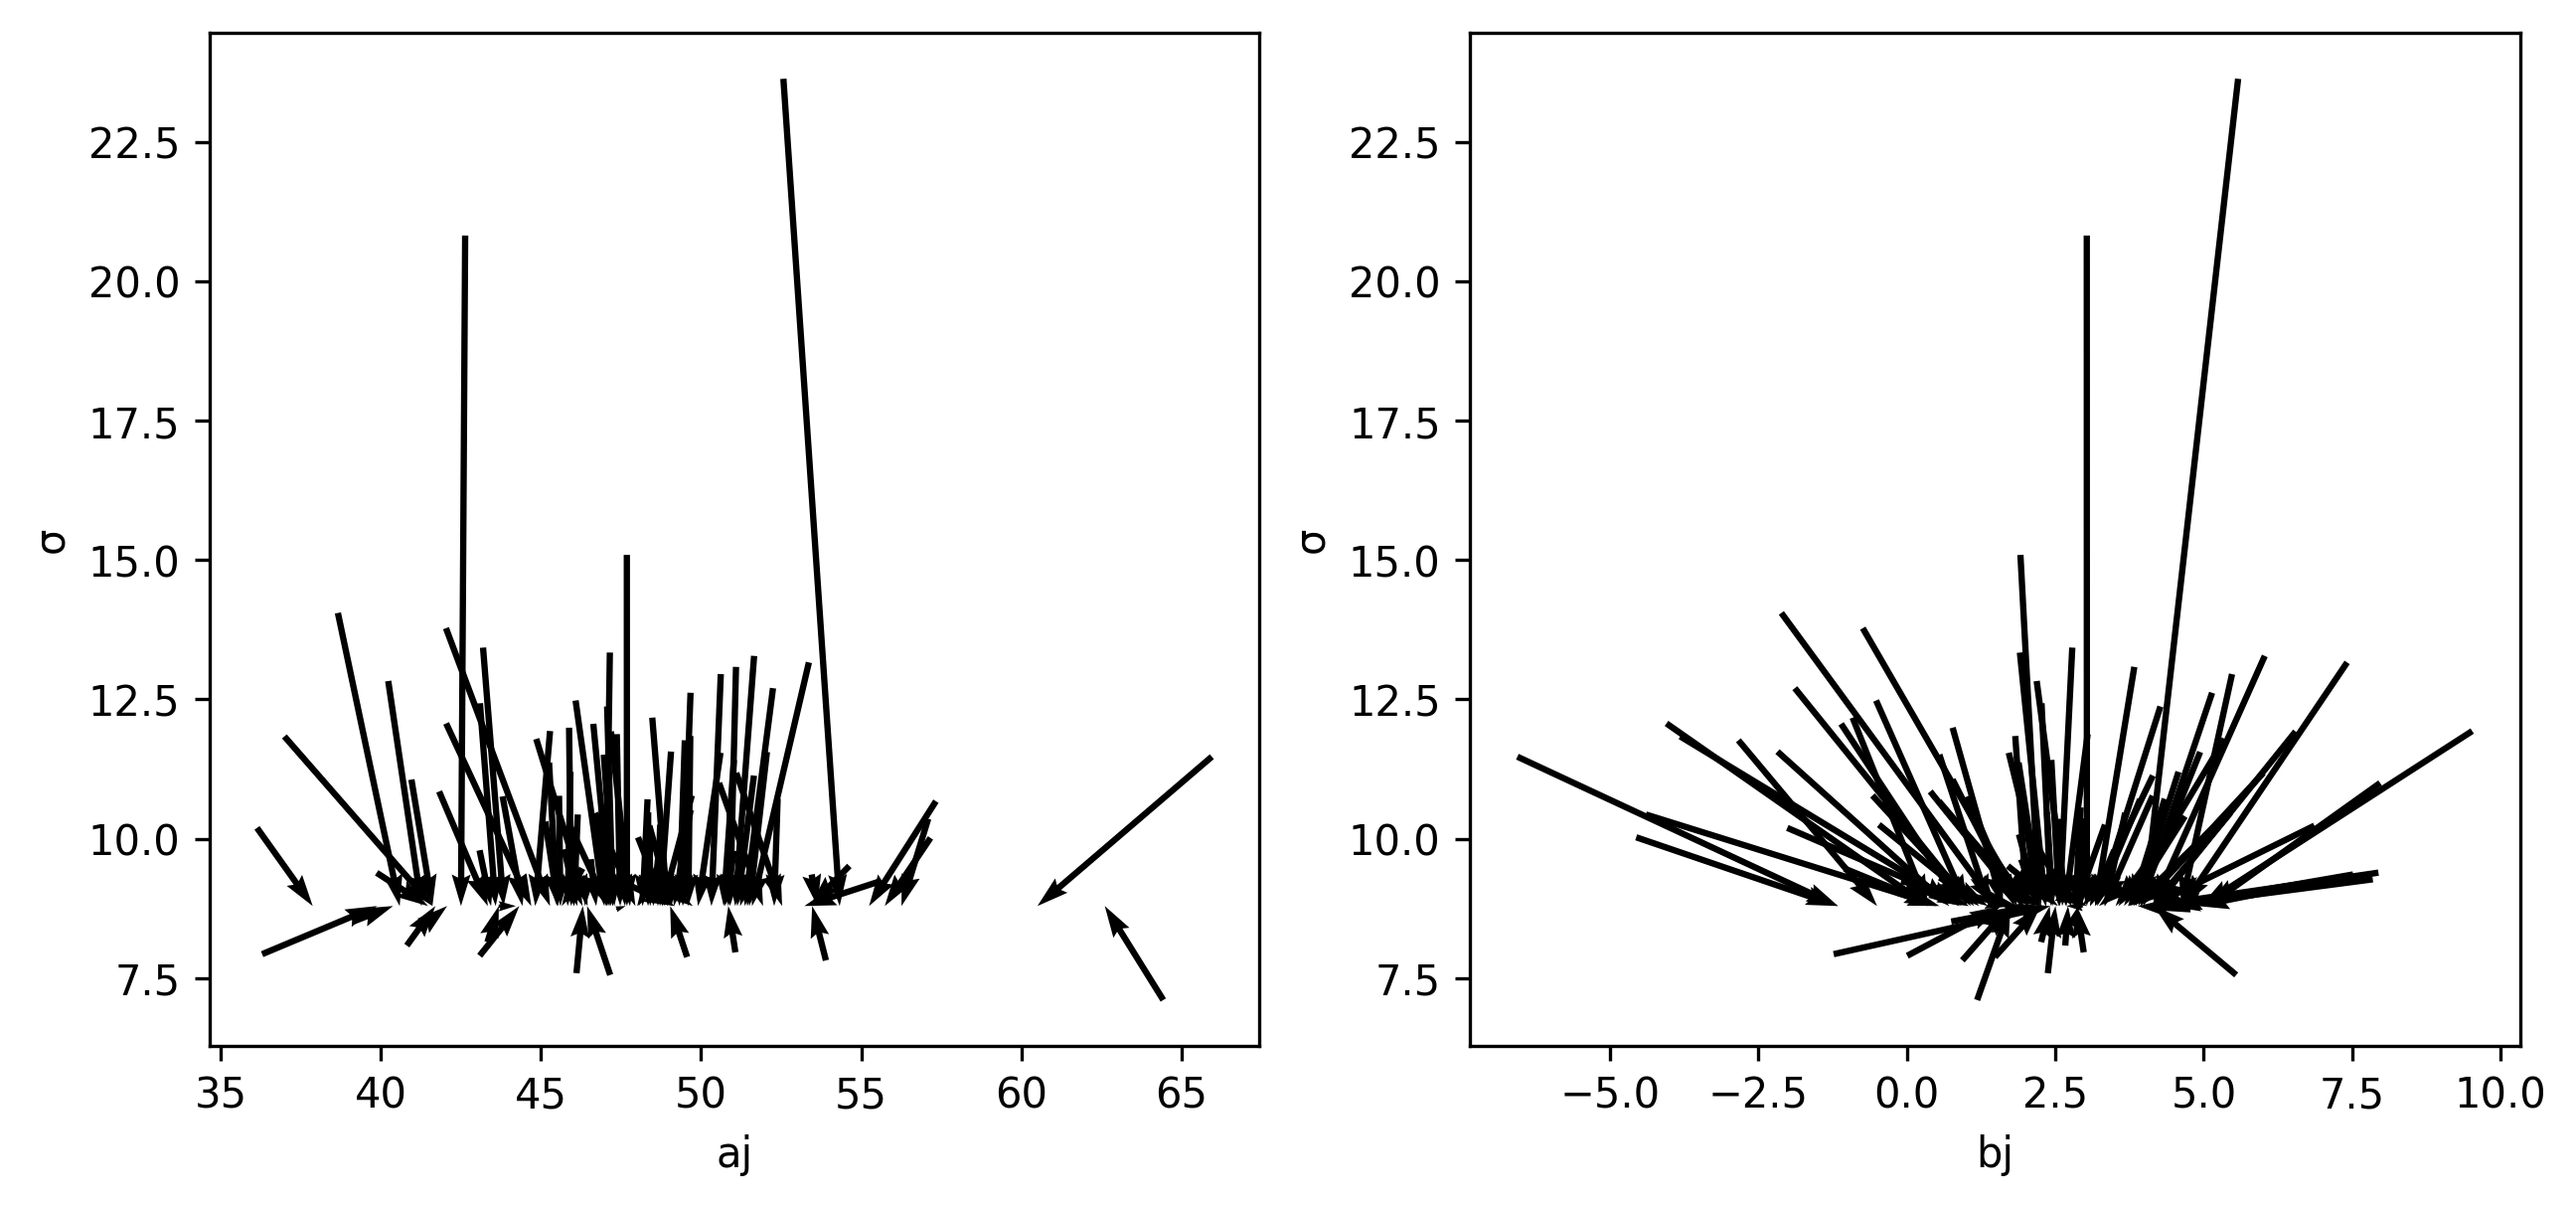

In [69]:
Xa = w_j_mean1[:,0]
Ya = sigma_j_mean1 
Ua = w_j_mean2[:,0]-Xa
Va = sigma_mean2-Ya

Xb = w_j_mean1[:,1]
Yb = sigma_j_mean1 
Ub = w_j_mean2[:,1]-Xb
Vb = sigma_mean2-Yb

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4.5),dpi=300)
ax1.quiver(Xa, Ya, Ua, Va,angles='xy',scale_units='xy', scale=1)
ax2.quiver(Xb, Yb, Ub, Vb,angles='xy',scale_units='xy', scale=1)

ax1.set_xlabel('aj')
ax1.set_ylabel('σ')
ax2.set_xlabel('bj')
ax2.set_ylabel('σ')
plt.show()

By adopting a full hierarchical scheme from an unpooled scheme, both the intercept ($a_j$) and the slope ($b_j$) components of wj shrink toward a smaller area in the parameter space. This is because by imposing hyper-paramters shared among schools, the $w_j$ terms of all the schools become more similar.

The error terms ($\sigma$) of most schools decrease, but those of some schools increase. In particular, the schools with higher errors in the unpooled scheme experience higher reduction in the error terms. This makes sense because a hierarchical scheme exploit information on the hyper-paramters shared among schools, so schools with fewers students that would have a very uncertain estimates of $w_j$ in the independent (unpooled) case benefit more from the hierarchical model. This reduction of errors for most schools is at the cost of a slight increase of errors for some schools.